# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd


strategyArray = []
gainArray     = []
lossArray     = []

#originalDataSet = pd.read_csv('dataset', sep = ',',header = None)
originalDataSet = pd.read_csv('reduced_dataset', sep = ',',header = None)
scaler          = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = gainArray

    print(data)
    axis.boxplot(data)
    axis.set_title("Gain error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1), fontsize = 14)
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotDistribution(regressor):
    features, result = loadDataset()
    regressor.fit(features, result)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))

    axis.scatter(result[:, 0], result[:, 1])
    axis.scatter(predicted[:, 0], predicted[:, 1], c = "m")

    axis.set_title(strategyArray[-1])
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

# Putting all together

In [8]:
gainArray = []
lossArray = []

[3.5        3.58333333 2.41666667 2.66666667 2.25      ] => 2.88 (+/- 1.11)
[3.41666667 3.16666667 3.41666667 3.         4.33333333] => 3.47 (+/- 0.92)


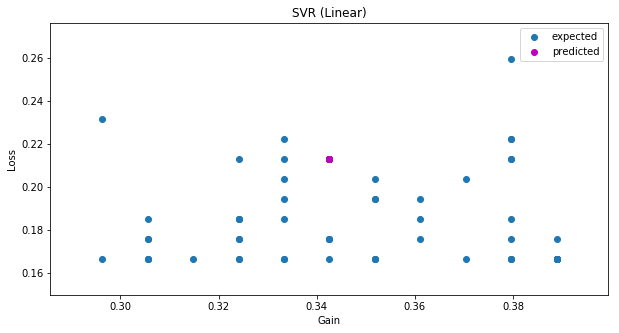

In [9]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")
plotDistribution(linearSVR)

[3.57973977 3.71443025 2.45721363 2.55915958 2.44959974] => 2.95 (+/- 1.14)
[2.0976577  2.1451943  1.48647956 1.64988709 1.52244175] => 1.78 (+/- 0.57)


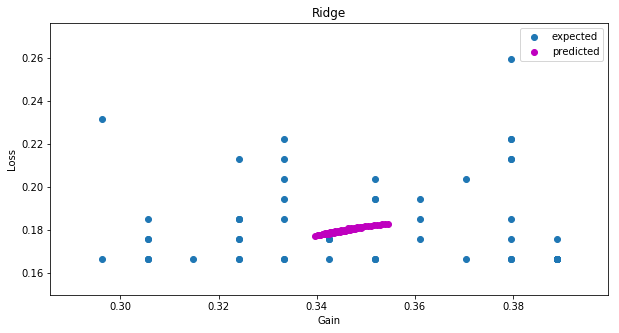

In [10]:
ridge = MultiOutputRegressor(KernelRidge(alpha = 1.0))
trainModel(ridge)
strategyArray.append("Ridge")
plotDistribution(ridge)

[3.35763889 3.36111111 2.60416667 2.53819444 2.44444444] => 2.86 (+/- 0.82)
[2.1875     2.29166667 1.54166667 1.56597222 1.48611111] => 1.81 (+/- 0.70)


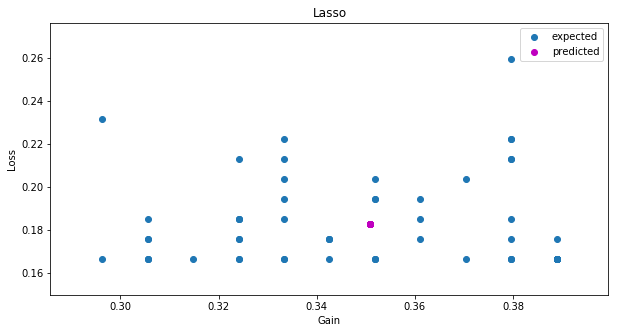

In [11]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")
plotDistribution(lasso)

[3.26714591 3.27557692 2.59975362 2.56209752 2.41611214] => 2.82 (+/- 0.74)
[2.26095345 2.22498391 1.50696743 1.40245018 1.18827114] => 1.72 (+/- 0.88)


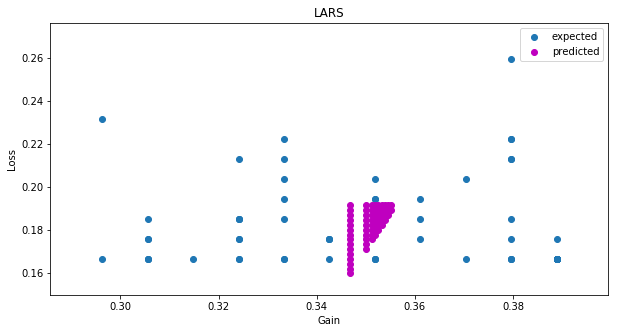

In [12]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("LARS")
plotDistribution(lars)

[2.92906612 2.73273252 2.57512515 2.91470198 2.22580315] => 2.68 (+/- 0.52)
[2.12943626 2.05556068 1.41674763 1.56481477 0.91713654] => 1.62 (+/- 0.89)


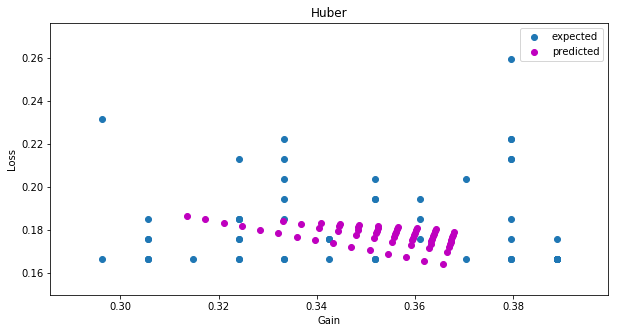

In [13]:
huber = MultiOutputRegressor(linear_model.HuberRegressor())
trainModel(huber)
strategyArray.append("Huber")
plotDistribution(huber)

[2.63333333 3.         2.5        2.         2.18333333] => 2.46 (+/- 0.70)
[2.3        2.13333333 1.55       1.2        1.43333333] => 1.72 (+/- 0.84)


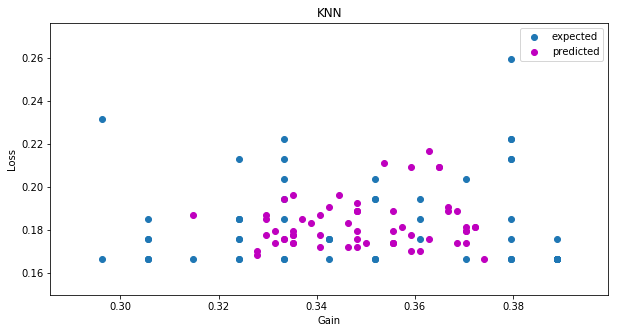

In [14]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)
strategyArray.append("KNN")
plotDistribution(knn)

[2.625      2.88166667 2.91166667 2.74083333 2.96083333] => 2.82 (+/- 0.25)
[2.59       1.845      1.7275     1.4475     1.33333333] => 1.79 (+/- 0.88)


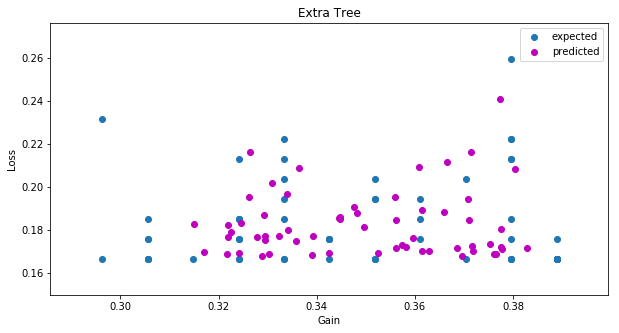

In [15]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)
strategyArray.append("Extra Tree")
plotDistribution(bret)

# Plotting error boxplots

[array([3.5       , 3.58333333, 2.41666667, 2.66666667, 2.25      ]), array([3.57973977, 3.71443025, 2.45721363, 2.55915958, 2.44959974]), array([3.35763889, 3.36111111, 2.60416667, 2.53819444, 2.44444444]), array([3.26714591, 3.27557692, 2.59975362, 2.56209752, 2.41611214]), array([2.92906612, 2.73273252, 2.57512515, 2.91470198, 2.22580315]), array([2.63333333, 3.        , 2.5       , 2.        , 2.18333333]), array([2.625     , 2.88166667, 2.91166667, 2.74083333, 2.96083333])]


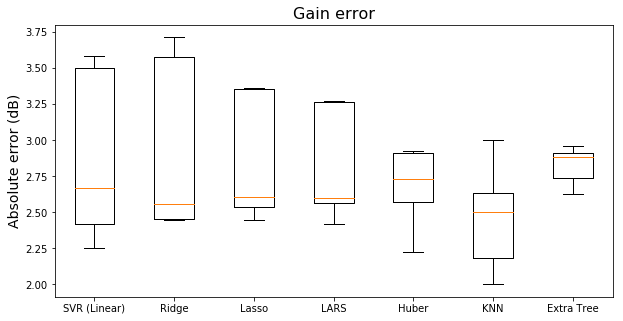

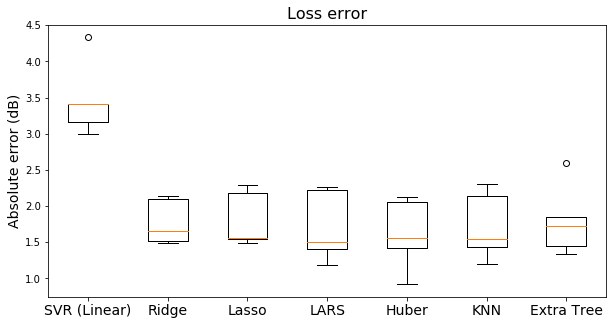

In [16]:
plotGainError()
plotLossError()